In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import ot 
import os

os.chdir('.')

# import our gw, (bounded) pgw, mpgw 
from lib.gromov import gromov_wasserstein,cost_matrix_d,tensor_dot_param,tensor_dot_func,gwgrad_partial1,partial_gromov_wasserstein,partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist,PGW_dist_with_penalty


# import ugw 

from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure
from lib.unbalanced_gromov_wasserstein.unbalancedgw.batch_stable_ugw_solver import log_batch_ugw_sinkhorn

In [44]:
# Compute GW distance 


n=50
m=60

# Note, should normalize p0, p1. 
p=np.ones(n)/n
q=np.ones(m)/m


X=np.random.rand(n,2) 
Y=np.random.rand(m,2)


# Compute cost matrix  (This is Euclidean distance square) 
C1=cost_matrix_d(X,X)
C2=cost_matrix_d(Y,Y) 

# compute the GW distance 

gamma=gromov_wasserstein(C1, C2, p, q,G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False,line_search=False)
# Always set line_search=False. log=False 

gw_dist=GW_dist(C1,C2,gamma)
#
print('GW distance between X, Y is', gw_dist)


GW distance between X, Y is 0.026226371800967825


In [48]:
# Compute the PGW distance 

n=50
m=50

X=np.random.rand(n,2)
Y=np.random.rand(m,2)

# Set p,q such that each point of p,q have same mass, which is alpha 
alpha=1/n
p=np.ones(n)*alpha   
q=np.ones(m)*alpha 

C1=cost_matrix_d(X,X)
C2=C1.copy()
#C2=cost_matrix_d(Y,Y)

Lambda=1/2*(C1.max()**2+C2.max()**2) # If C1 contains infimum, change it to max(C1[D]), where D=C1!=np.inf 
# Lambda can be any value such that 2\lambda>= max(M)\approx (max(C1)^2+max(C2)^2). 

# compute the GW distance 
# If you have prior knowledge of initial guess G0, add it to the function. 
gamma=partial_gromov_ver1(C1, C2, p, q,G0=None,Lambda=Lambda,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False,line_search=False)

pgw_trans,pgw_penalty=PGW_dist_with_penalty(C1,C2,gamma,p,q,Lambda)
pgw_D=pgw_trans+pgw_penalty


print('PGW transportation cost',pgw_trans)
print('PGW penalty',pgw_penalty)
print('PGW distance',pgw_D)






PGW transportation cost -1.4155343563970743e-17
PGW penalty 0.0
PGW distance -1.4155343563970743e-17


In [31]:
# Compute the mass-constraint PGW 


n=50
m=60


X=np.random.rand(n,2)
Y=np.random.rand(m,2)

p0=np.ones(n)/n
p1=np.ones(m)/n

mass=min(p0.sum(),p1.sum())
# m can be set to any value such that 0<m<=min(p0.sum(),p1.sum())

C1=cost_matrix_d(X,X)
C2=cost_matrix_d(Y,Y)

# compute the GW distance 

gamma=partial_gromov_wasserstein(C1, C2, p0, p1,G0=None,m=mass,thres=1, numItermax=100*n0, tol=1e-5,log=False, verbose=False,line_search=False)

mpgw_D=MPGW_dist(C1,C2,gamma)

print('MPGW discrepancy is',mpgw_D)



MPGW discrepancy is 0.010456636592993195


In [34]:
n=50
m=60


X=np.random.rand(n,2)
Y=np.random.rand(m,2)

p0=np.ones(n)/n
p1=np.ones(m)/n

# m can be set to any value such that 0<m<=min(p0.sum(),p1.sum())

C1=cost_matrix_d(X,X)
C2=cost_matrix_d(Y,Y)

# set hyper-parameters, convert numpy to pytorch 
eps=0.004 # If you see nan error, increase this value 
rho=0.001
rho2=rho
nb_try=1
Cx=torch.from_numpy(C1).to(torch.float32).reshape((nb_try,n,n))
Cy=torch.from_numpy(C2).to(torch.float32).reshape((nb_try,m,m))
mu=torch.from_numpy(p).to(torch.float32).reshape([nb_try,n])
nu=torch.from_numpy(q).to(torch.float32).reshape([nb_try,m])
# or you can use the following to generate the hyperparameters. 

def init_param_ugw(C1,C2,p=None,q=None):
    n,m=C1.shape[0],C2.shape[0]
    n_pos,n_unl=n,m
    nb_try=1
    if p is None:
        mu = (torch.ones([n_pos]) / n_pos).expand(nb_try, -1)
    else:
        mu=torch.from_numpy(p).to(torch.float32).reshape([nb_try,n])
    if q is None:
        nu = (torch.ones([n_unl]) / n_unl).expand(nb_try, -1)
    else:
        nu=torch.from_numpy(q).to(torch.float32).reshape([nb_try,m])
    
    grid_eps = [2. ** k for k in range(-9, -8, 1)]
    grid_rho = [2. ** k for k in range(-10, -4, 1)]
    eps=grid_eps[0]
    rho=grid_rho[0]
    rho2=grid_rho[0]
    Cx=torch.from_numpy(C1).to(torch.float32).reshape((nb_try,n,n))
    Cy=torch.from_numpy(C2).to(torch.float32).reshape((nb_try,m,m))
    return mu,nu,eps,rho,rho2,Cx,Cy

gamma = log_batch_ugw_sinkhorn(mu, Cx, nu, Cy, init=None,
                        eps=eps, rho=rho, rho2=rho2,
                        nits_plan=3000, tol_plan=1e-5,
                        nits_sinkhorn=3000, tol_sinkhorn=1e-6)

# Transportation plan is Gamma. 



In [20]:
n_pos=10
nb_try=1
A=(torch.ones([n_pos]) / n_pos).expand(nb_try, -1)
print(A.shape)

torch.Size([1, 10])


In [3]:
# Set up a solver for KL-(U)GW
# Set rho=float("Inf") to run balanced GW computation
eps = 1.0
rho, rho2 = 1.0, 1.0

# Generate two mm-spaces with euclidean metrics
a, dx, a1 = generate_measure(n_batch=1, n_sample=5, n_dim=3)
b, dy, a2 = generate_measure(n_batch=1, n_sample=6, n_dim=2)
# Reduce the first axis to keep one space (method generates batches)
a, b, dx, dy = a[0], b[0], dx[0], dy[0]

# Compute the bi-convex relaxation of the UGW problem
pi, gamma = exp_ugw_sinkhorn(a, dx, b, dy, init=None, eps=eps,
                             rho=rho, rho2=rho2,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)

# Compute the loss
cost = ugw_cost(pi, gamma, a, dx, b, dy, eps=eps, rho=rho, rho2=rho2)
print("Cost of the biconvex relaxation: ", cost)

Cost of the biconvex relaxation:  tensor(0.1508)


In [ ]:
# without prior knowledge 

time1=time.time()
gamma1=ot.gromov.gromov_wasserstein(C1,C2,p,q)
n=X.shape[0]
time2=time.time()
print('time of gromov_wasserstein is', time2-time1)


# time1=time.time()
# gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
# time2=time.time()

# print('time of v1 is', time2-time1)
# print('gamma 2 mass',gamma2.sum())

time1=time.time()
gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('mass of G2',gamma2.sum())
print('time of v1 is', time2-time1)



mass=0.8
G0=np.outer(p,q)/(np.sum(p)*np.sum(q))*mass
print('G0 mass is',G0.sum())
time1=time.time()
gamma2_1=partial_gromov_wasserstein(C1,C2,p,q, G0=G0,m=0.8,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('time of primal is', time2-time1)

C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
time1=time.time()
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=8.0, rho2=None,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
time2=time.time()
gamma3=gamma3T.numpy()
print('time of ugw is', time2-time1)

time of gromov_wasserstein is 3.9769787788391113
mass of G2 0.7999999999999995
time of v1 is 112.78411388397217
G0 mass is 0.799999999999999
time of primal is 65.26119589805603


Gamma1


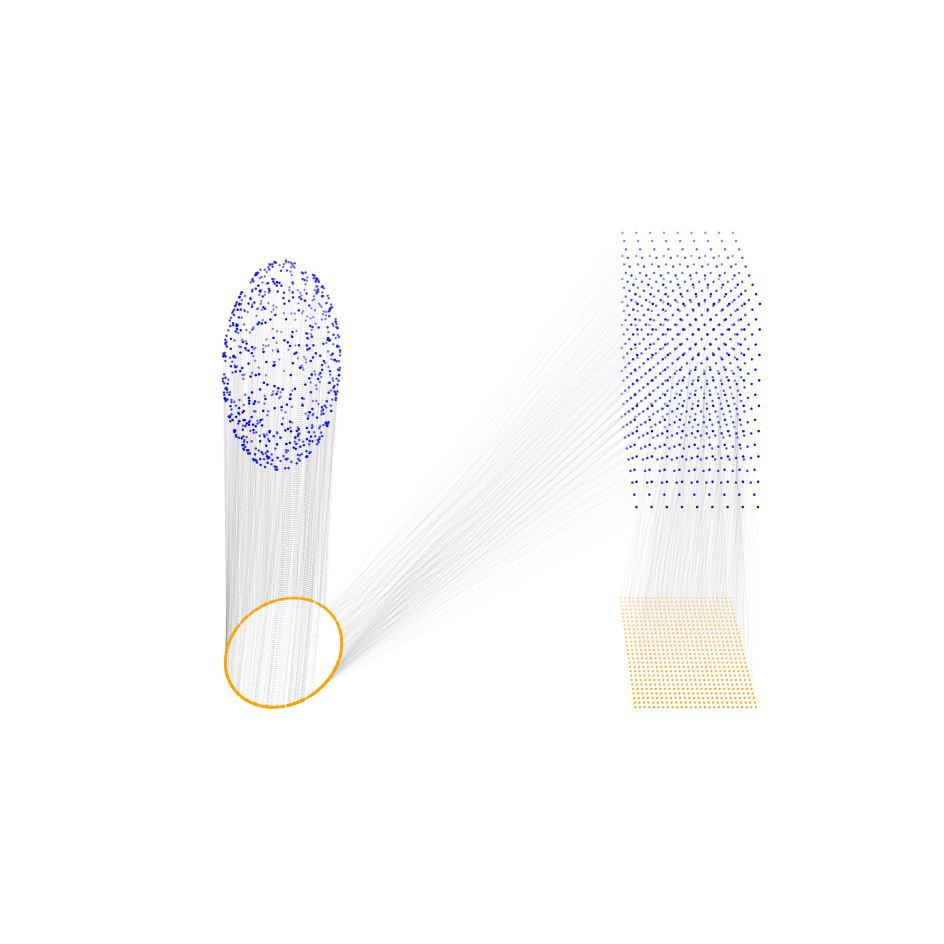

Gamma2


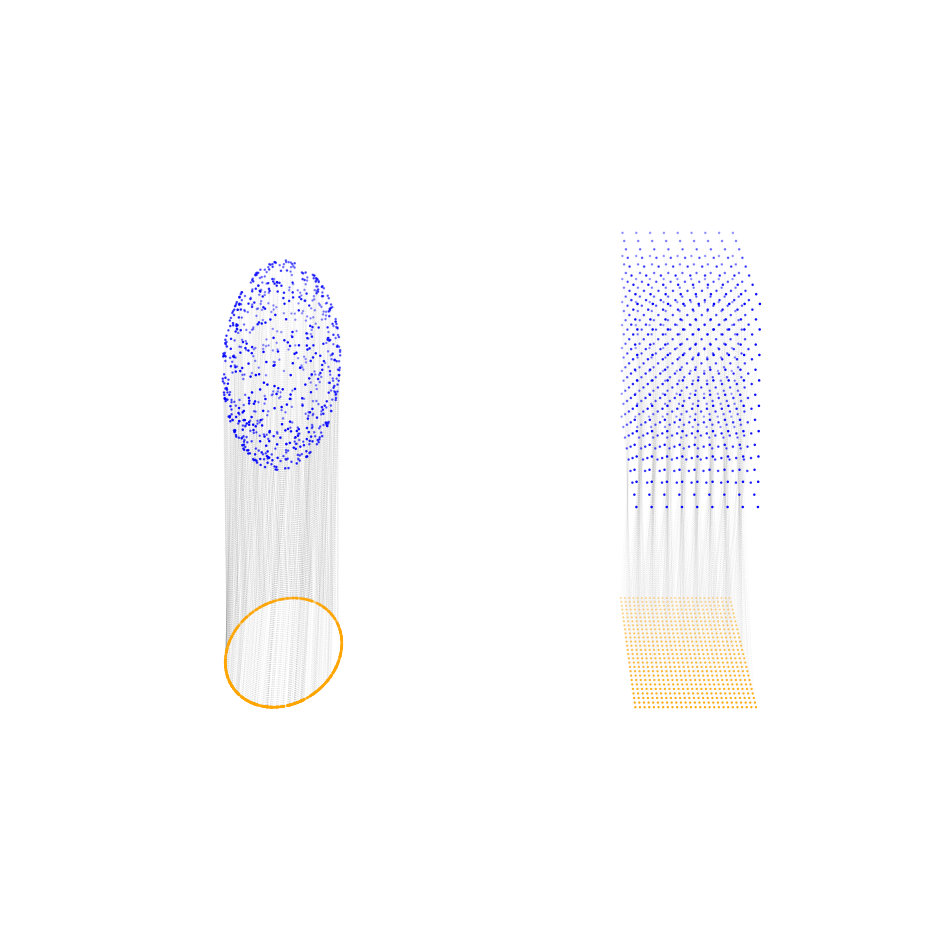

Gamma21


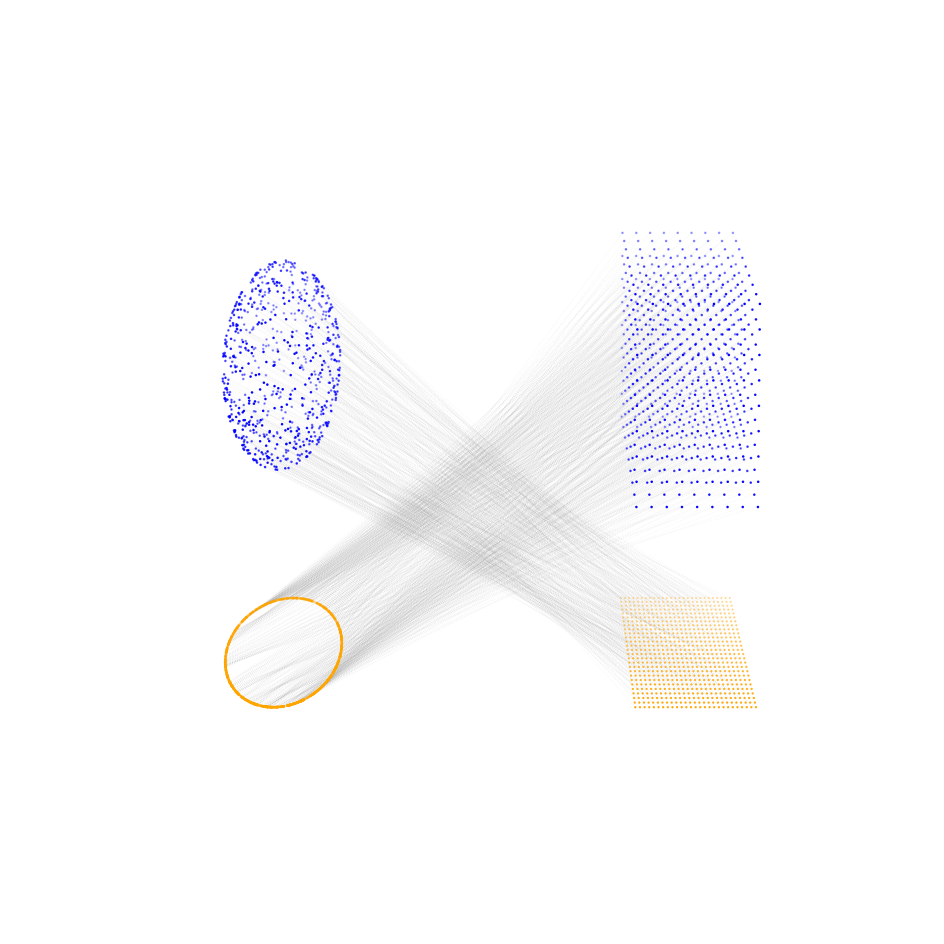

Gamma3


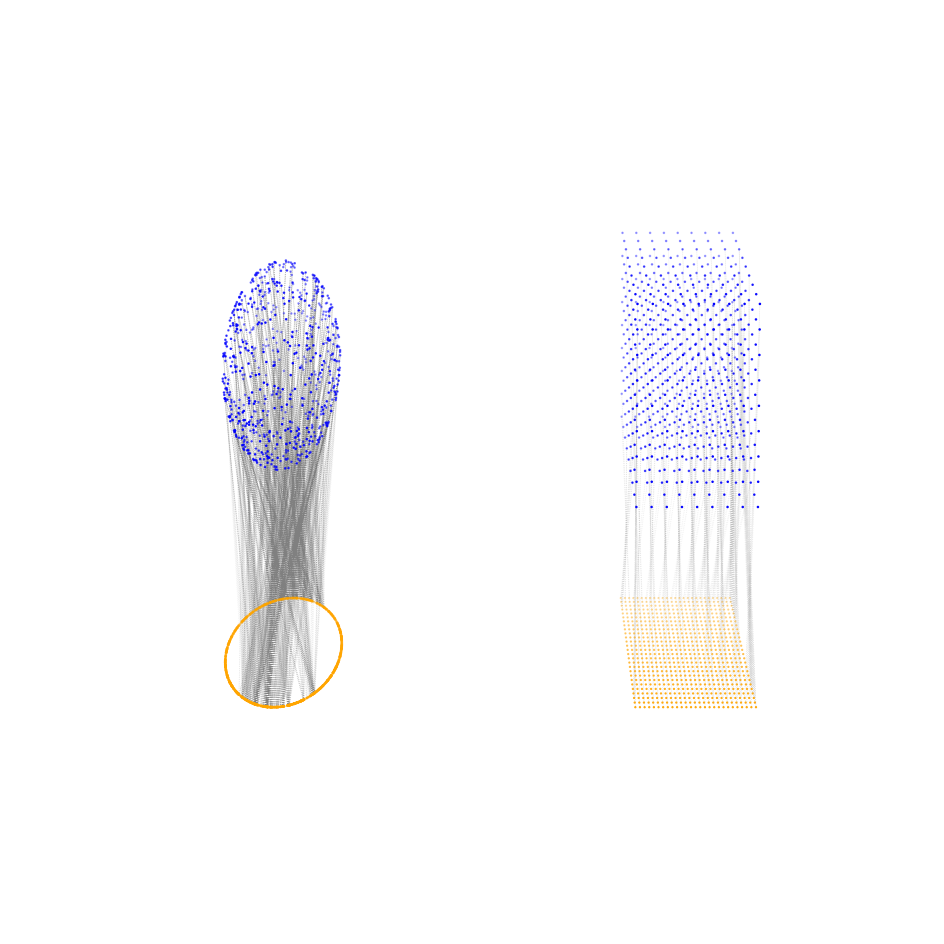

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def embed_3d(X):
    N,d=X.shape
    if d<3:
        X1=np.zeros((N,3))
        X1[:,0:d]=X
    else:
        X1=X.copy()
    return X1




def visual_plot(X,Y,p,q,gamma,eps=0.0004,save_name=None):
    X=embed_3d(X)
    Y=embed_3d(Y)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Adding legend
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('white') 
    
    # Plotting the scatter plot for shape X in orange
    scatter_X = ax.scatter(X[:,0], X[:,1], X[:,2], s=1000*p, color='orange', label='Shape X')

    # Plotting the scatter plot for shape Y in blue
    scatter_Y = ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=1000*q,color='blue', label='Shape Y')
    
    # show gamma:
    for (idx,x_point) in enumerate(X):
        for (idy,y_point) in enumerate(Y):
            if gamma[idx,idy]>eps:
                ax.plot([x_point[0], y_point[0]], [x_point[1], y_point[1]], [x_point[2], y_point[2]], linestyle=':', linewidth=0.5, alpha=0.1, color='grey')


        
    ax.view_init(10,90,0)
    if save_name is not None:
        plt.savefig('result/shape_matching/'+save_name+'.png',dpi=200,bbox_inches='tight', pad_inches=0)
    # Show plot
    plt.show()

print('Gamma1')
visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
print('Gamma2')
visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

print('Gamma21')
visual_plot(X,Y,p,q,gamma2_1,save_name='pr_pgw_3',eps=4e-4)


gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=2.1*1e-5)

In [49]:
p

array([0.06724896, 0.51953095, 0.01369687, 0.52800693, 0.5338431 ])

In [46]:
gamma1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

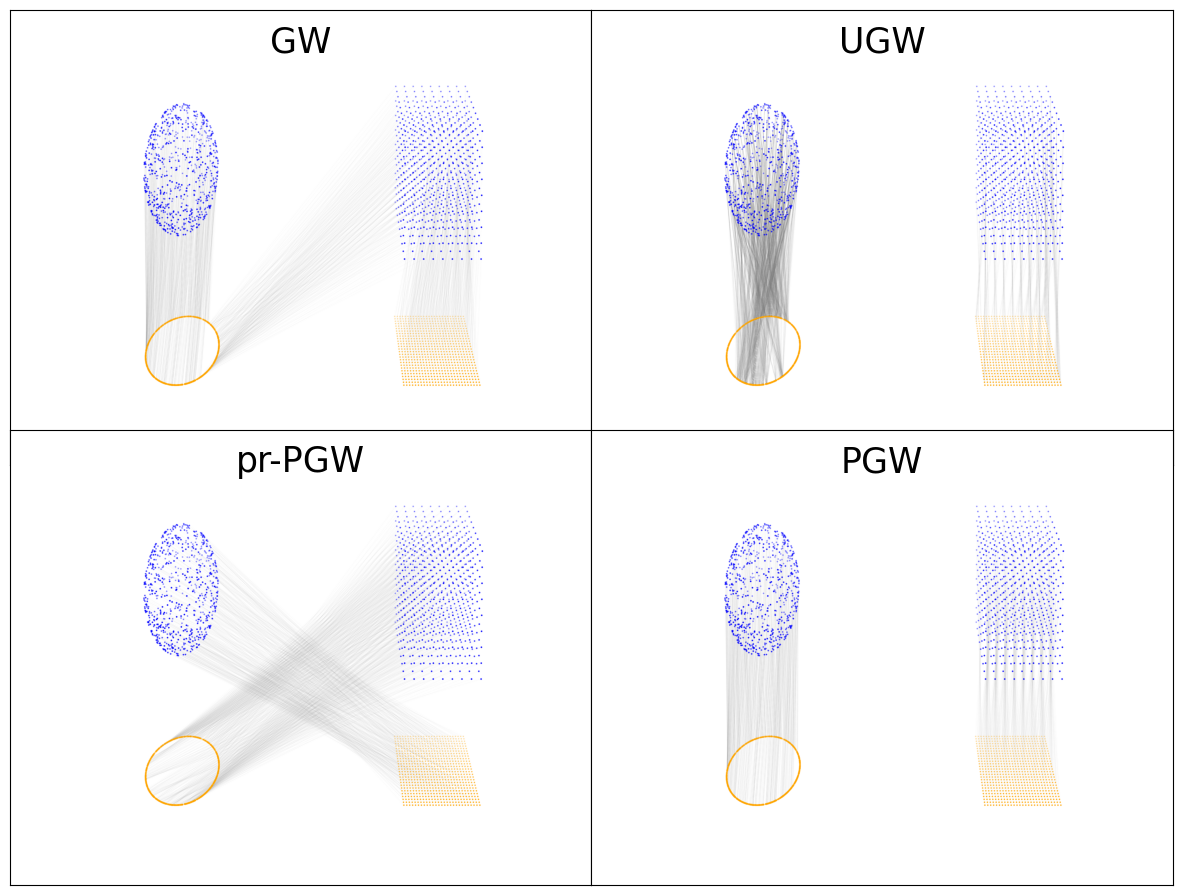

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
rows=2
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(3*5, 12*5))
# Remove the gaps between subplots

save_path='result/shape_matching/'
figure_list=['gw_3','ugw_3','pr_pgw_3','pgw_3']
for (i,(method,figure)) in enumerate(zip(['GW','UGW','pr-PGW','PGW'],figure_list)):
    i1,i2=np.divmod(i,2)
    #print('i1',i1)
    #print('i2',i2)
    path=save_path+figure+'.png'
    img = mpimg.imread(path)
    img_crop=img[200:-200,:,:]
    axs[i1,i2].imshow(img_crop)
    axs[i1,i2].set_xticks([])
    axs[i1,i2].set_yticks([])
#    axs[i1,i2].set_xlabel(method,fontsize=15)
    axs[i1,i2].set_title(method,fontsize=25,y=0.95, pad=-14)

plt.subplots_adjust(wspace=0, hspace=-0.9)

#plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.savefig('result/shape_matching/shape_wo.png',dpi=200, bbox_inches='tight', pad_inches=0)
plt.savefig('result/shape_matching/shape_wo.jpg',dpi=200, bbox_inches='tight', pad_inches=0)
plt.savefig('result/shape_matching/shape_wo.pdf',dpi=200, bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()

In [ ]:
# with prior knowledge
G0=np.ones(n)/n*3/5
time1=time.time()
gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,G0=G0,Lambda=300.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()

print('time of v1 is', time2-time1)


G0=np.ones(n)/n*3/5
#mass=0.8
G0=np.outer(p,q)/(np.sum(p)*np.sum(q))*mass
print('G0 mass is',G0.sum())
time1=time.time()
gamma2_1=partial_gromov_wasserstein(C1,C2,p,q, G0=G0,m=0.8,numItermax=1000*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('time of primal is', time2-time1)

C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
time1=time.time()
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=8.0, rho2=None,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
time2=time.time()
gamma3=gamma3T.numpy()
print('time of ugw is', time2-time1)

print('Gamma1')
visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
print('Gamma2')
visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

print('Gamma21')
visual_plot(X,Y,p,q,gamma2_1,save_name='pr_pgw_3',eps=4e-4)


gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=2.1*1e-5)

In [39]:

p=np.abs(np.random.rand(5))
q=np.abs(np.random.rand(4))
nb_dummies=1

lstlab = np.array([0, 1])
labels_a = np.append(np.array([0]*(len(p)-nb_dummies)),
                     np.array([1]*(nb_dummies)))

G0=np.ones((6,5))
G0[0:5,0:4]=np.outer(p,q)
res = 0
for i in range(G.shape[1]):
    for lab in lstlab:
        temp = G[labels_a == lab, i]
        print(temp.shape)
        res += (np.linalg.norm(temp, 1))**0.5
        


(4,)
(1,)
(4,)
(1,)
(4,)
(1,)
(4,)
(1,)


array([0.12382613])

In [42]:
a=temp.sum()
b=np.linalg.norm(temp, 1)
print(a)
print(b)

0.12382612640079965
0.12382612640079965


In [36]:
labels_a == lab

array([False, False, False, False,  True])

In [78]:
#@title Some preprocessing functions from Kaggle

import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
import pandas as pd
import random
import tqdm

def vector_to_voxel(vector, shape=(16,16,16)):
    vec_shape = list(vector.shape[:-1]) + list(shape)
    voxel = vector.reshape(*vec_shape)
    return voxel

def voxel_to_pointcloud(voxel, num_points=None, shuffle=True):
    assert len(voxel.shape)==3, f"Voxel should be a 3D tensor. Given shape {voxel.shape}!=3"
    x, y, z = np.nonzero(voxel)
    point_cloud = np.concatenate([np.expand_dims(x,axis=1), np.expand_dims(y,axis=1), np.expand_dims(z,axis=1)], axis=1)
    if num_points is not None:
        if point_cloud.shape[0] >= num_points:
            ids = list(range(point_cloud.shape[0]))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
        else:
            diff = num_points - len(point_cloud)
            padding = np.zeros([diff, 3])
            point_cloud = np.concatenate([point_cloud, padding], axis=0)
            ids = list(range(len(point_cloud)))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
    return point_cloud


def vector_to_pointcloud(vector, num_points=None, shuffle=True):
    voxel = vector_to_voxel(vector)
    voxel = np.squeeze(voxel)
    point_cloud = voxel_to_pointcloud(voxel, num_points, shuffle)
    return point_cloud

In [79]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra

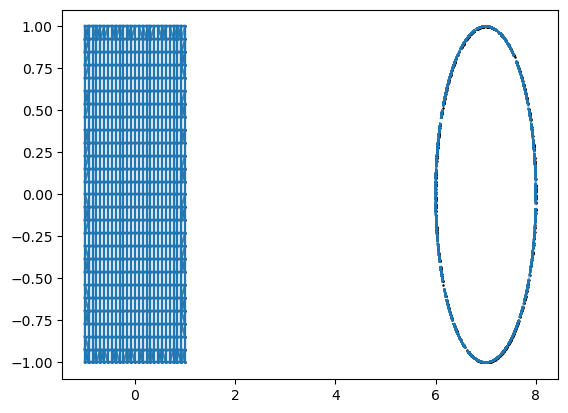

In [80]:


pc=X.copy()
D_euc=np.sqrt(((pc[np.newaxis,:,:2]-pc[:,np.newaxis,:2])**2).sum(-1))

knnG = kneighbors_graph(pc[:,:2], n_neighbors=4,mode='distance')
D_graph = dijkstra(knnG,directed=False)
C1=D_graph.copy()
# Just for visualization
plt.scatter(pc[:,0], pc[:,1],c='k',s=0.6)
for i in knnG.indices:
  for j in knnG[i].indices:
    plt.plot([pc[i,0], pc[j,0]], [pc[i,1],pc[j,1]],c='C0',alpha=.5)
plt.show()


A=C1>100
C1[A]=100



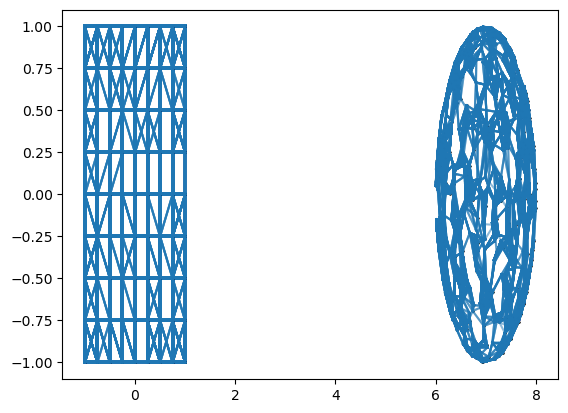

In [81]:
pc=Y.copy()
D_euc=np.sqrt(((pc[np.newaxis,:,:3]-pc[:,np.newaxis,:3])**2).sum(-1))

knnG = kneighbors_graph(pc[:,:3], n_neighbors=6,mode='distance')
D_graph = dijkstra(knnG,directed=False)
C2=D_graph.copy()
#C[D_graph>=100]=100
# Just for visualization
plt.scatter(pc[:,0], pc[:,1],c='k',s=0.6)
for i in knnG.indices:
  for j in knnG[i].indices:
    plt.plot([pc[i,0], pc[j,0]], [pc[i,1],pc[j,1]],c='C0',alpha=.5)
plt.show()



B=C2>100
C2[B]=200

In [82]:
# gamma1=ot.gromov.gromov_wasserstein(C1,C2,p,q,tol=1e-5)
# gamma2,log1=partial_gromov_v1(C1,C2,p,q,Lambda=20.0,numItermax=100000,tol=1e-5,log=False)
# print(gamma2.sum())
C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=30.0, rho2=30.0,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
gamma3=gamma3T.numpy()
print('G3 is',gamma3.sum())

G3 is 0.30150732


Gamma3


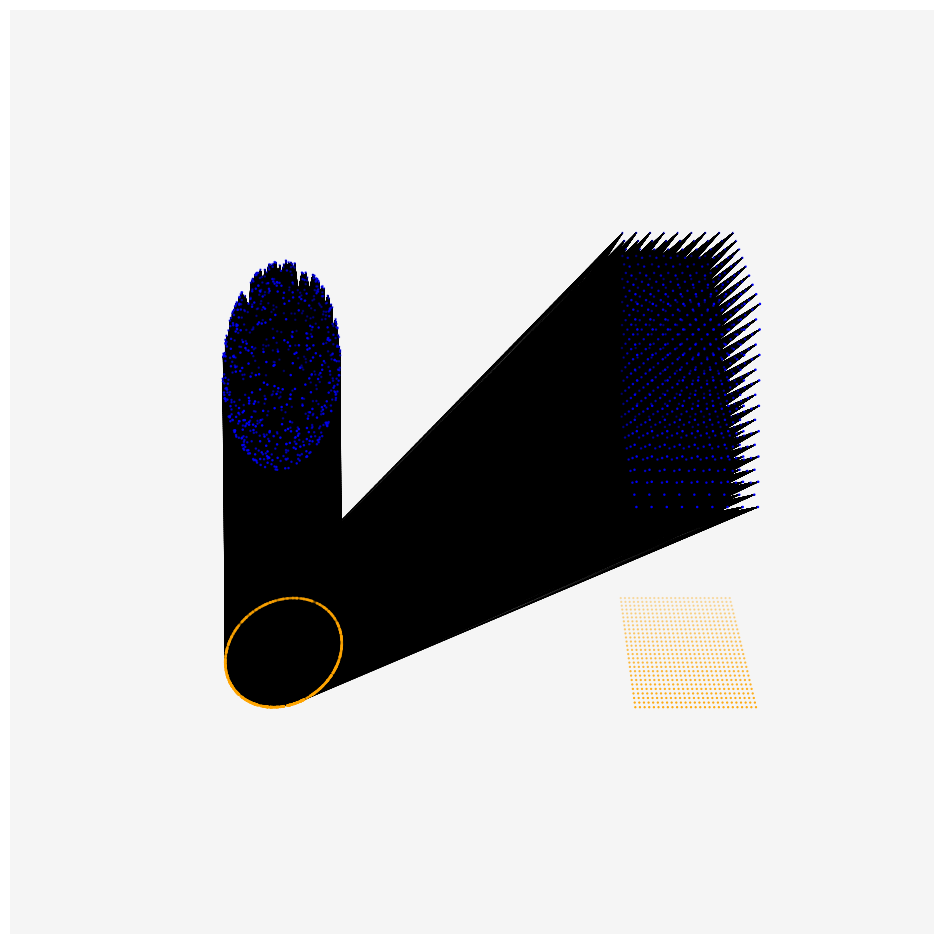

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def embed_3d(X):
    N,d=X.shape
    if d<3:
        X1=np.zeros((N,3))
        X1[:,0:d]=X
    else:
        X1=X.copy()
    return X1




def visual_plot(X,Y,p,q,gamma,eps=0.0004,save_name=None):
    X=embed_3d(X)
    Y=embed_3d(Y)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Adding legend
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('whitesmoke') 
    
    # Plotting the scatter plot for shape X in orange
    scatter_X = ax.scatter(X[:,0], X[:,1], X[:,2], s=1000*p, color='orange', label='Shape X')

    # Plotting the scatter plot for shape Y in blue
    scatter_Y = ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=1000*q,color='blue', label='Shape Y')
    
    # show gamma:
    for (idx,x_point) in enumerate(X):
        for (idy,y_point) in enumerate(Y):
            if gamma[idx,idy]>eps:
                ax.plot([x_point[0], y_point[0]], [x_point[1], y_point[1]], [x_point[2], y_point[2]], linestyle=':', linewidth=0.5, alpha=0.3, color='black')


        
    ax.view_init(10,90,0)
    if save_name is not None:
        plt.savefig('result/shape_matching/'+save_name+'.png',dpi=200,bbox_inches='tight', pad_inches=0)
    # Show plot
    plt.show()

# print('Gamma1')
# visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
# print('Gamma2')
# visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=4.0e-8)

In [227]:
@nb.njit()
def random_projections(d,n_projections,Type=0,dtype=np.float64,seed=-1):
    '''
    input: 
    d: int 
    n_projections: int

    output: 
    projections: d*n torch tensor

    '''
    if seed>0:
        np.random.seed(seed)
    if Type==0:
        Gaussian_vector=np.random.normal(0,1,size=(d,n_projections)).astype(dtype)
        projections=Gaussian_vector/np.sqrt(np.sum(np.square(Gaussian_vector),0))
        projections=projections.T

    elif Type==1:
        r=np.int64(n_projections/d)+1
        projections=np.zeros((d*r,d),dtype)
        for i in range(r):
            H=np.random.randn(d,d).astype(dtype)
            Q,R=np.linalg.qr(H)
            projections[i*d:(i+1)*d]=Q
        projections=projections[0:n_projections]
    return projections

# @nb.njit()
# def recover_indice(indice_X,indice_Y,L):
#     '''
#     input:
#         indice_X: n*1 float torch tensor, whose entry is integer 0,1,2,....
#         indice_Y: m*1 float torch tensor, whose entry is integer 0,1,2,.... 
#         L: n*1 list, whose entry could be 0,1,2,... and -1.
#         L is the original transportation plan for sorted X,Y 
#         L[i]=j denote x_i->y_j and L[i]=-1 denote we destroy x_i. 
#         If we ignore -1, it must be in increasing order  
#     output:
#         mapping_final: the transportation plan for original unsorted X,Y
        
#         Eg. X=[2,1,3], indice_X=[1,0,2]
#             Y=[3,1,2], indice_Y=[1,2,0]
#             L=[0,1,2] which means the mapping 1->1, 2->2, 3->3
#         return: 
#             L=[2,1,0], which also means the mapping 2->2, 1->1,3->3.
    
#     '''
#     n=L.shape[0]
#     indice_Y_mapped=np.where(L>=0,indice_Y[L],-1)
#     mapping=np.stack((indice_X,indice_Y_mapped))
#     mapping_final=mapping[1].take(mapping[0].argsort())
#     return mapping_final

@nb.njit()
def recover_indice(indice_X,indice_Y):
    mapping=np.stack((indice_X,indice_Y))
    mapping_final=mapping[1].take(mapping[0].argsort())
    return mapping_final

@nb.njit()
def L_to_Gamma(L,m):
    n=L.shape[0]
    gamma=np.zeros((n,m))
    for i in range (n):
        gamma[i,L[i]]=1
    return gamma
    
@nb.njit()
def expect_gamma(X_theta_list,Y_theta_list):
    N,n=X_theta_list.shape
    gamma=np.zeros((n,n))
    for i in range(N):
        X_theta,Y_theta=X_theta_list[i],Y_theta_list[i]
        X_argsort,Y_argsort=X_theta.argsort(),Y_theta.argsort()
        L=recover_indice(X_argsort,Y_argsort)
        gamma_theta=L_to_Gamma(L,n)
        gamma+=gamma_theta
    gamma=gamma/N
    return gamma

@nb.njit(fastmath=True,cache=True)
def cost_matrix_d(X,Y,p):
    '''
    input: 
        X: (n,) float np array
        Y: (m,) float np array
    output:
        M: n*m matrix, M_ij=c(X_i,Y_j) where c is defined by cost_function.
    
    '''
    n,d=X.shape
    m,d=Y.shape
    M=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            M[i,j]=np.sum(np.abs(X[i]-Y[j])**p)
    return M

# @nb.njit()
# def expect_cost(X,Y,gamma_bar):
#     N,n=X_theta_list.shape
#     gamma=np.zeros((n,n))
#     for i in range(N):
#         X_theta,Y_theta=X_theta_list[i],Y_theta_list[i]
#         X_argsort,Y_argsort=X_theta.argsort(),Y_theta.argsort()
#         L=recover_indice(X_argsort,Y_argsort)
#         gamma+=L_to_Gamma(L,n)
#     gamma/=N
#     return gamma
    


n,d=2,2
X=np.random.rand(n,d)
Y=X.copy()+np.random.rand(d) #np.random.rand(n,d)*2
Z=X.copy()-np.random.rand(d) #np.random.rand(n,d)*3

N=1
theta_list=random_projections(d,N)
X_theta_list=theta_list.dot(X.T)
Y_theta_list=theta_list.dot(Y.T)
Z_theta_list=theta_list.dot(Z.T)

p,q=np.ones(n),np.ones(n)
#N_id=0
#X_theta=X_theta_list[N_id]
#Y_theta=Y_theta_list[N_id]
#X_argsort,Y_argsort=X_theta.argsort(),Y_theta.argsort()
#L=recover_indice(X_argsort,Y_argsort)
power=2
gamma_XY=expect_gamma(X_theta_list,Y_theta_list)
M_XY=cost_matrix_d(X,Y,power)
cost_XY=np.power(np.sum(M_XY*gamma_XY),1/power)

# gamma_XY2=ot.lp.emd(p,q,M_XY)
# cost_XY2=np.power(np.sum(M_XY*gamma_XY2),1/power)

gamma_XZ=expect_gamma(X_theta_list,Z_theta_list)
M_XZ=cost_matrix_d(X,Z,power)
cost_XZ=np.power(np.sum(M_XZ*gamma_XZ),1/power)

gamma_YZ=expect_gamma(Y_theta_list,Z_theta_list)
M_YZ=cost_matrix_d(Y,Z,power)
cost_YZ=np.power(np.sum(M_YZ*gamma_YZ),1/power)
    
#print(cost_XY-cost_XY2)
print(cost_XY+cost_XZ-cost_YZ)
print(cost_XY+cost_YZ-cost_XZ)
print(cost_XZ+cost_YZ-cost_XY)


0.014564364805022767
1.0978340792518466
0.33146795035808096


In [220]:
gamma_XY

array([[1., 0.],
       [0., 1.]])

In [200]:
gamma_XZ

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [201]:
gamma_YZ

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])